<a href="https://colab.research.google.com/github/schizohub/ML_projects/blob/main/Improving_Tashkent_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, LogisticRegression,Ridge, SGDRegressor,BayesianRidge, Perceptron
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.svm import NuSVR, SVC, LinearSVR
from xgboost import XGBRegressor, XGBRFRegressor

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/anvarnarz/praktikum_datasets/main/housing_data_08-02-2021.csv')
df.head()

,location,district,rooms,size,level,max_levels,price
0,"город Ташкент, Юнусабадский район, Юнусабад 8-...",Юнусабадский,3,57,4,4,52000
1,"город Ташкент, Яккасарайский район, 1-й тупик ...",Яккасарайский,2,52,4,5,56000
2,"город Ташкент, Чиланзарский район, Чиланзар 2-...",Чиланзарский,2,42,4,4,37000
3,"город Ташкент, Чиланзарский район, Чиланзар 9-...",Чиланзарский,3,65,1,4,49500
4,"город Ташкент, Чиланзарский район, площадь Актепа",Чиланзарский,3,70,3,5,55000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7565 entries, 0 to 7564
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   location    7565 non-null   object
 1   district    7565 non-null   object
 2   rooms       7565 non-null   int64 
 3   size        7565 non-null   object
 4   level       7565 non-null   int64 
 5   max_levels  7565 non-null   int64 
 6   price       7565 non-null   object
dtypes: int64(3), object(4)
memory usage: 413.8+ KB


In [4]:
def drop_outliers(df):
  new_df = df.copy()
  a = ['Площадьземли:1сот','Договорная']
  b = new_df['size'].isin([a[0]])
  new = new_df.drop(new_df[b].index).copy()
  new['size'] = new['size'].astype(float)
  new['size'] = new['size'].apply(lambda x: np.round(x)).astype(int)
  y = new['price'].isin([a[1]])
  mean_value = new.drop(new[y].index)['price'].astype(int).mean()
  new['price'].replace({'Договорная':np.round(mean_value)},inplace=True)
  new['price'] = new['price'].astype(int)
  return new

In [5]:
new_df = drop_outliers(df)

In [6]:
df[df['size']=='Площадьземли:1сот']

,location,district,rooms,size,level,max_levels,price
5347,"город Ташкент, Яшнободский район, Дархон",Яшнободский,4,Площадьземли:1сот,3,5,150000


In [7]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7564 entries, 0 to 7564
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   location    7564 non-null   object
 1   district    7564 non-null   object
 2   rooms       7564 non-null   int64 
 3   size        7564 non-null   int64 
 4   level       7564 non-null   int64 
 5   max_levels  7564 non-null   int64 
 6   price       7564 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 730.8+ KB


In [8]:
new_df['size'].unique()

array([   57,    52,    42,    65,    70,    28,    30,    32,    51,
          67,    35,    43,    90,    80,    69,    96,    76,    45,
          27,    64,    26,    72,   100,    63,    48,   102,    78,
          34,    56,    98,    93,    60,    82,   120,   110,    95,
          68,    46,    40,    53,    54,    20,    50,    36,    58,
          74,    94,    85,   125,    22,    66,    37,    61,    88,
          38,    55,    91,   111,   107,    62,    75,    84,   117,
          47,    33,   187,    29,    11,   122,   119,   164,    92,
          89,   208,    44,    86,   150,    83,    49,   142,   115,
         350,    81,    59,   145,   116,    77,    24,    41,   255,
         266,   210,   140,   141,   165,   215,   128,    97,   130,
         105,   137,    71,   160,   118,   152,    21,   104,   180,
         109,   135,    73,    39,   157,   112,   106,   214,   235,
          16,   300,    79,     5,   203,   114,   246,    87,   121,
          99,   129,

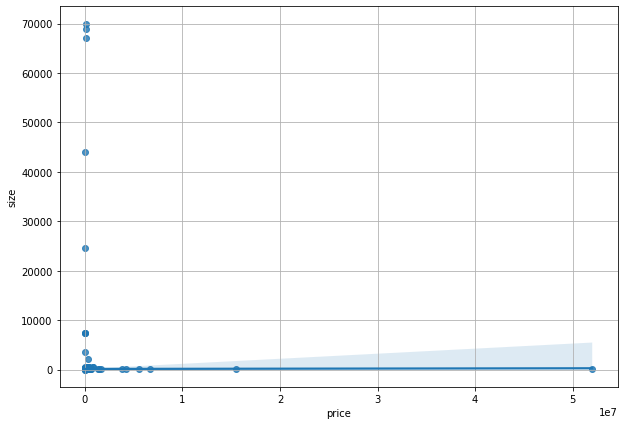

In [9]:
plt.figure(figsize=(10,7))
sns.regplot(data=new_df, x='price',y='size')
plt.grid()
plt.show()

In [10]:
def find_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    return outliers

In [11]:
outliers = find_outliers_IQR(new_df['size'])
print("number of outliers: "+ str(len(outliers)))
print("max outlier value: "+ str(outliers.max()))
print("min outlier value: "+ str(outliers.min()))

number of outliers: 314
max outlier value: 70000
min outlier value: 141


In [12]:
new_df.iloc[outliers.index]

,location,district,rooms,size,level,max_levels,price
189,"город Ташкент, Мирзо-Улугбекский район, Буюк И...",Мирзо-Улугбекский,4,187,2,5,210000
205,"город Ташкент, Яккасарайский район, Яккасарой ...",Яккасарайский,4,164,5,6,170000
224,"город Ташкент, Мирзо-Улугбекский район, Ахмад ...",Мирзо-Улугбекский,4,208,2,3,93000
236,"город Ташкент, Яккасарайский район, 1-й проезд...",Яккасарайский,3,150,3,6,170000
250,"город Ташкент, Чиланзарский район, Чиланзар 10...",Чиланзарский,5,142,5,5,120000
...,...,...,...,...,...,...,...
7134,"город Ташкент, Чиланзарский район, Домбрабад",Чиланзарский,3,68,2,2,37000
7177,"город Ташкент, Яккасарайский район, Мукими",Яккасарайский,3,78,6,8,115000
7187,"город Ташкент, Учтепинский район, Чиланзар 31-...",Учтепинский,3,82,5,9,40000
7324,"город Ташкент, Чиланзарский район, Домбрабад",Чиланзарский,3,90,3,4,48500


In [13]:
outliers1 = find_outliers_IQR(new_df['price'])
print("number of outliers: "+ str(len(outliers1)))
print("max outlier value: "+ str(outliers1.max()))
print("min outlier value: "+ str(outliers1.min()))

number of outliers: 540
max outlier value: 52000000
min outlier value: 118000


In [14]:
new_df.iloc[outliers1.index]

,location,district,rooms,size,level,max_levels,price
154,"город Ташкент, Мирабадский район, Фидокор (Чех...",Мирабадский,4,100,5,8,142000
173,"город Ташкент, Мирзо-Улугбекский район, Ирригатор",Мирзо-Улугбекский,3,117,2,5,125000
189,"город Ташкент, Мирзо-Улугбекский район, Буюк И...",Мирзо-Улугбекский,4,187,2,5,210000
205,"город Ташкент, Яккасарайский район, Яккасарой ...",Яккасарайский,4,164,5,6,170000
223,"город Ташкент, Мирзо-Улугбекский район, Ул.Кор...",Мирзо-Улугбекский,3,100,2,6,119000
...,...,...,...,...,...,...,...
7335,"город Ташкент, Мирзо-Улугбекский район, Буюк И...",Мирзо-Улугбекский,3,88,2,4,132000
7336,"город Ташкент, Юнусабадский район, Юнусабад 14...",Юнусабадский,3,76,2,4,65000
7422,"город Ташкент, Юнусабадский район, Юнусабад-4",Юнусабадский,2,56,3,4,33500
7467,"город Ташкент, Юнусабадский район, Юнусабад 9-...",Юнусабадский,1,38,4,5,24500


In [15]:

outliers2 = find_outliers_IQR(new_df['rooms'])
print("number of outliers: "+ str(len(outliers2)))
print("max outlier value: "+ str(outliers2.max()))
print("min outlier value: "+ str(outliers2.min()))

number of outliers: 332
max outlier value: 10
min outlier value: 5


In [16]:
new_df.iloc[outliers2.index]

,location,district,rooms,size,level,max_levels,price
63,"город Ташкент, Чиланзарский район, Чиланзарски...",Чиланзарский,5,82,4,4,70000
64,"город Ташкент, Учтепинский район, Чиланзар 23-...",Учтепинский,5,120,9,9,52000
160,"город Ташкент, Юнусабадский район, Юнусабад 14...",Юнусабадский,5,107,5,5,50000
200,"город Ташкент, Мирзо-Улугбекский район, Феруза-1",Мирзо-Улугбекский,5,100,4,4,48000
232,"город Ташкент, Олмазорский район, 1-й проезд Ч...",Олмазорский,5,110,5,5,63500
...,...,...,...,...,...,...,...
7374,"город Ташкент, Яшнободский район, Асалабад-1",Яшнободский,3,75,1,4,52000
7400,"город Ташкент, Мирабадский район, Туркистан",Мирабадский,3,88,4,9,45000
7419,"город Ташкент, Юнусабадский район, Шахристон",Юнусабадский,3,111,4,9,85000
7422,"город Ташкент, Юнусабадский район, Юнусабад-4",Юнусабадский,2,56,3,4,33500


In [17]:
outliers3 = find_outliers_IQR(new_df['level'])
print("number of outliers: "+ str(len(outliers3)))
print("max outlier value: "+ str(outliers3.max()))
print("min outlier value: "+ str(outliers3.min()))

number of outliers: 78
max outlier value: 19
min outlier value: 10


In [18]:
new_df.iloc[outliers3.index]

,location,district,rooms,size,level,max_levels,price
70,"город Ташкент, Яшнободский район, Жаркургон",Яшнободский,1,46,11,11,19765
114,"город Ташкент, Мирзо-Улугбекский район, площад...",Мирзо-Улугбекский,2,72,18,19,55000
364,"город Ташкент, Яккасарайский район, Нукус 2 а",Яккасарайский,3,75,10,16,70000
522,"город Ташкент, Яшнободский район, Корасув (Лис...",Яшнободский,2,80,10,10,71324
649,"город Ташкент, Учтепинский район, Чиланзар 30-...",Учтепинский,3,80,10,12,40000
...,...,...,...,...,...,...,...
7344,"город Ташкент, Юнусабадский район, Юнус абад-11",Юнусабадский,1,42,4,4,25500
7418,"город Ташкент, Юнусабадский район, Юнусабад-9",Юнусабадский,5,110,2,5,67000
7458,"город Ташкент, Юнусабадский район, Юнусабад-6",Юнусабадский,1,38,4,4,26500
7463,"город Ташкент, Олмазорский район, Нозимахоним",Олмазорский,2,56,2,4,36000


In [19]:
outliers4 = find_outliers_IQR(new_df['max_levels'])
print("number of outliers: "+ str(len(outliers4)))
print("max outlier value: "+ str(outliers4.max()))
print("min outlier value: "+ str(outliers4.min()))

number of outliers: 24
max outlier value: 25
min outlier value: 17


In [20]:
new_df.iloc[outliers4.index]

,location,district,rooms,size,level,max_levels,price
114,"город Ташкент, Мирзо-Улугбекский район, площад...",Мирзо-Улугбекский,2,72,18,19,55000
1420,"город Ташкент, Мирзо-Улугбекский район, жилой ...",Мирзо-Улугбекский,3,94,16,23,118000
1783,"город Ташкент, Мирзо-Улугбекский район, жилой ...",Мирзо-Улугбекский,3,80,12,25,200000
2913,"город Ташкент, Мирзо-Улугбекский район, Олой",Мирзо-Улугбекский,1,45,5,18,57000
3523,"город Ташкент, Яккасарайский район, Бабура",Яккасарайский,1,45,9,17,57853
3551,"город Ташкент, Яккасарайский район, Бабура",Яккасарайский,3,93,14,17,119562
3577,"город Ташкент, Яккасарайский район, Бабура",Яккасарайский,2,75,10,17,96421
3726,"город Ташкент, Мирзо-Улугбекский район, Метро ...",Мирзо-Улугбекский,3,95,5,18,66000
3815,"город Ташкент, Мирзо-Улугбекский район, Ниёзбе...",Мирзо-Улугбекский,3,94,16,23,118000
3954,"город Ташкент, Мирзо-Улугбекский район, Ниёзбе...",Мирзо-Улугбекский,3,94,16,23,118000


In [21]:
new_df.describe()

,rooms,size,level,max_levels,price
count,7564.000000,7564.000000,7564.000000,7564.000000,7.564000e+03
mean,2.625463,113.268905,3.699365,6.038340,7.132368e+04
std,1.085157,1491.312117,2.237409,2.613417,6.363596e+05
min,1.000000,1.000000,1.000000,1.000000,2.000000e+00
25%,2.000000,50.000000,2.000000,4.000000,3.500000e+04
50%,3.000000,66.000000,3.000000,5.000000,4.700000e+04
75%,3.000000,86.000000,5.000000,9.000000,6.800000e+04
max,10.000000,70000.000000,19.000000,25.000000,5.200000e+07


In [22]:
fig = px.histogram(new_df, x='size')
fig.show()

In [23]:
pic = px.histogram(new_df, 'price')
pic

In [24]:
def impute_outliers_IQR(df):
    new = df.copy()
    q1=new.quantile(0.25)
    q3=new.quantile(0.75)
    IQR=q3-q1
    upper = new[~(new>(q3+1.5*IQR))].max()
    lower = new[~(new<(q1-1.5*IQR))].min()
    new = np.where(new > upper,new.mean(),np.where(new < lower,new.mean(),new))
    return new

In [25]:
arr = np.array(new_df.columns)[2:]
new = new_df.copy()
for i in arr:
  new[i] = impute_outliers_IQR(new[i])

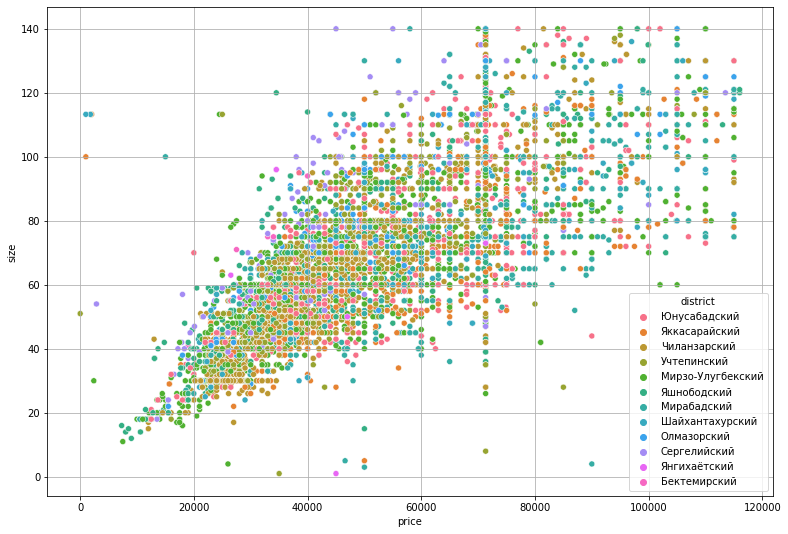

In [26]:
plt.figure(figsize=(13,9))
sns.scatterplot(data=new, x='price',y='size',hue='district')
plt.grid()
plt.show()

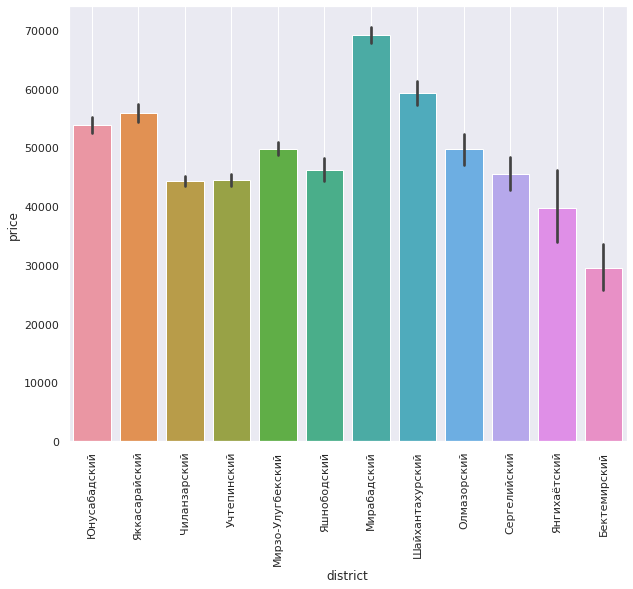

In [27]:
plt.figure(figsize=(10,8))
sns.set_theme()
sns.barplot(data=new, x='district', y='price')
plt.grid()
plt.xticks(rotation=90)
plt.show()

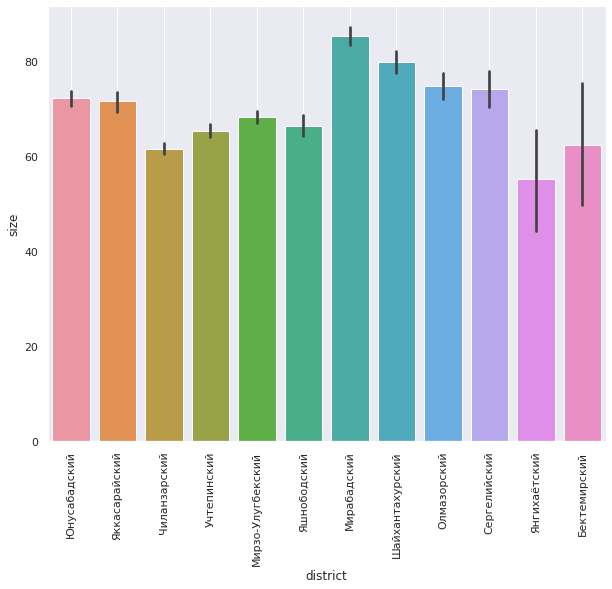

In [28]:
plt.figure(figsize=(10,8))
sns.set_theme()
sns.barplot(data=new, x='district', y='size')
plt.grid()
plt.xticks(rotation=90)
plt.show()

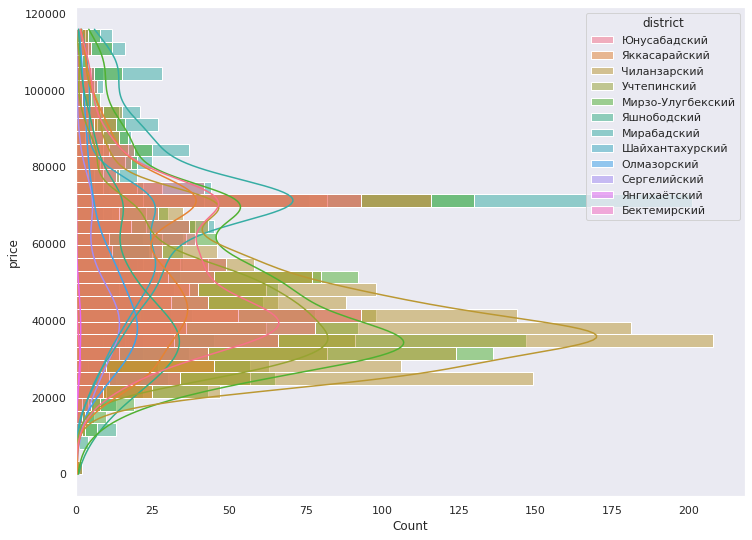

In [29]:
plt.figure(figsize=(12,9))
sns.histplot(data=new, y='price',hue='district',kde=True)
plt.grid()
plt.show()

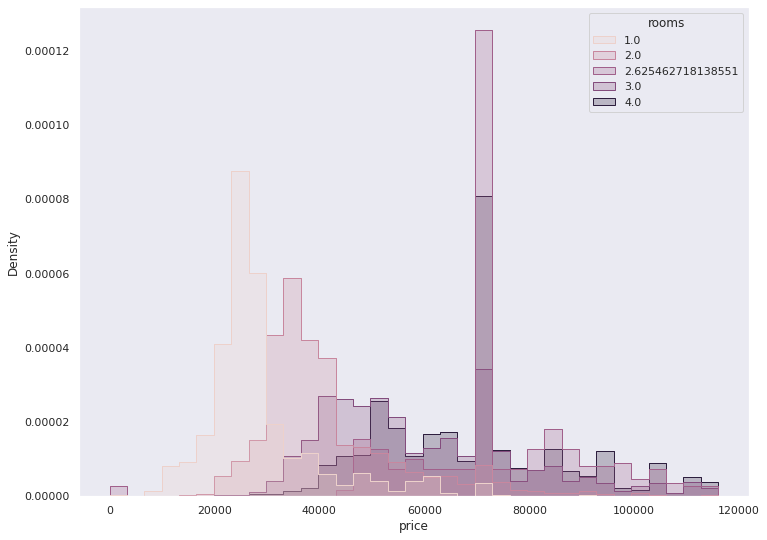

In [30]:
plt.figure(figsize=(12,9))
sns.histplot(data=new, x='price',hue='rooms',
             element='step',stat='density',
             common_norm=False)
plt.grid()
plt.show()

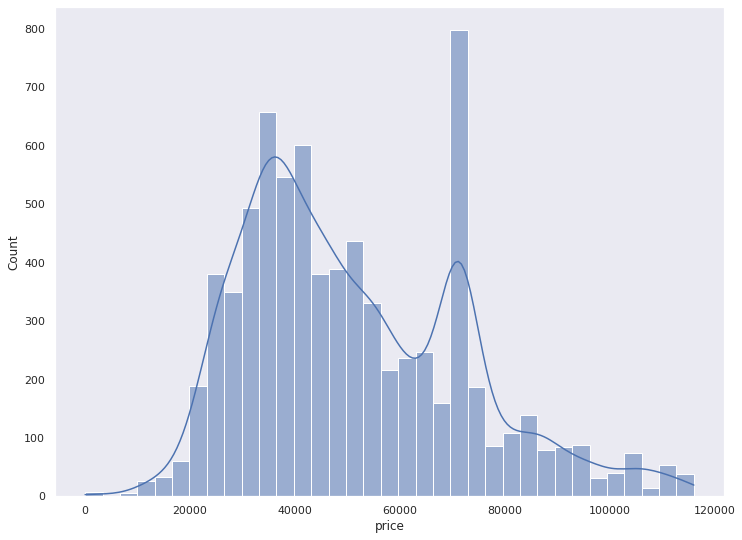

In [31]:
plt.figure(figsize=(12,9))
sns.histplot(data=new, x='price',kde=True)
plt.grid()
plt.show()

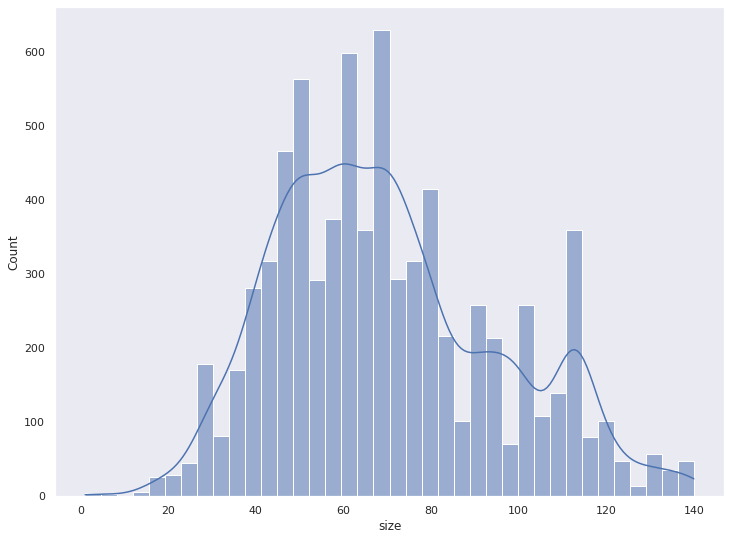

In [32]:
plt.figure(figsize=(12,9))
sns.set_theme()
sns.histplot(data=new, x='size',kde=True)
plt.grid()
plt.show()

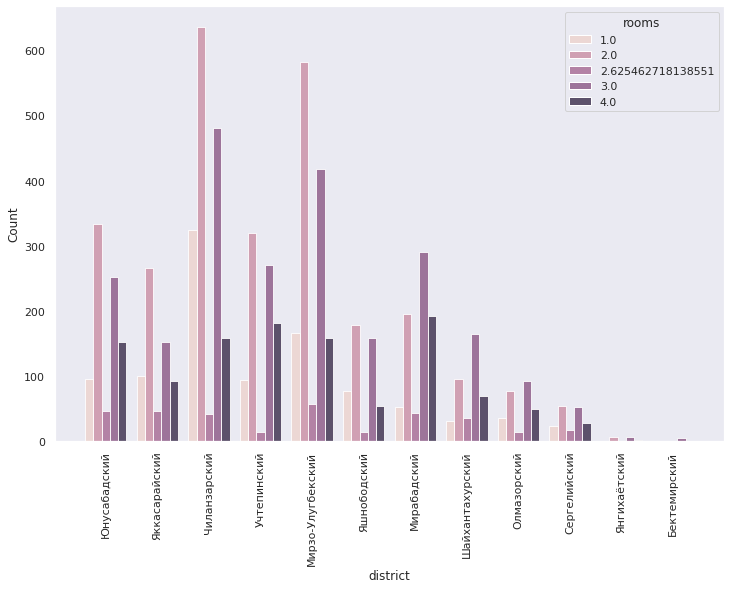

In [33]:
plt.figure(figsize=(12,8))
sns.histplot(data=new, x="district", hue="rooms", multiple="dodge", shrink=0.8)
plt.xticks(rotation=90)
plt.grid()
plt.show()

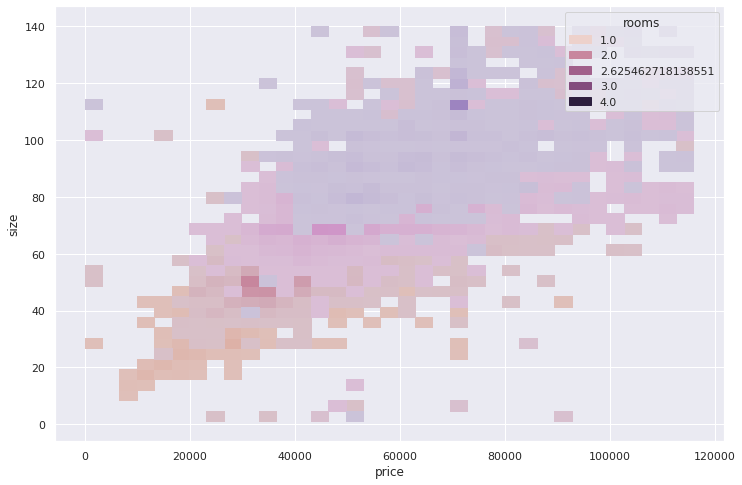

In [34]:
plt.figure(figsize=(12,8))
sns.histplot(new, x="price", y="size",hue='rooms')
plt.show()

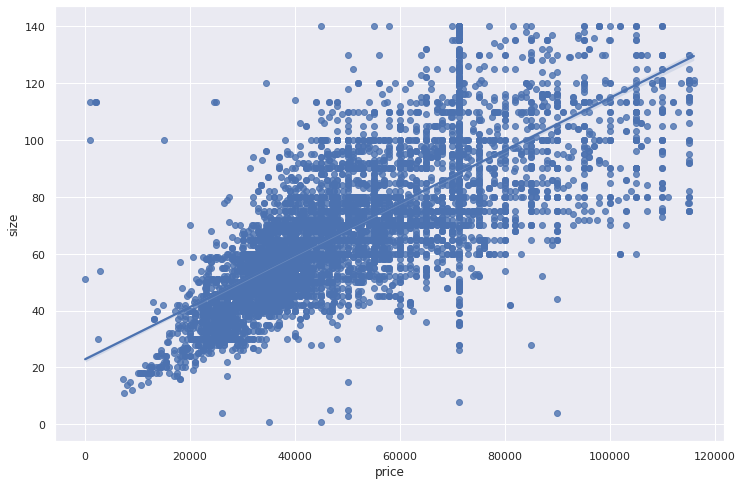

In [35]:
plt.figure(figsize=(12,8))
sns.regplot(data=new, x='price',y='size')
plt.show()

In [36]:
corr1 = new.corrwith(new['price'])*100

In [37]:
# var = new_df.iloc[outliers.index]['size'].mode()[0]
# new_df.iloc[outliers.index]['size'] = new_df.iloc[outliers.index]['size'].apply(lambda x: var).values

In [38]:
dropping = new_df[(new_df['size']<=7000)&(new_df['size']>=400)&(new_df['rooms']==10)].index[2:]

In [39]:
dropping = dropping.append(new_df[(new_df['size']>=1)&(new_df['size']<=20)&(new_df['rooms']==1)&(new_df['price']<10000)].index)

In [40]:
dropping = dropping.append(new_df[(new_df['price']>=230000)&(new_df['rooms']>=4)&(new_df['size']>480)].index)

In [41]:
dropping = dropping.append(new_df[(new_df['price']>=230000)&(new_df['rooms']<4)&(new_df['size']<100)].index)

In [42]:
dropping = dropping.append(new_df[new_df['price']<10000].index)

In [43]:
dropping = dropping.append(new_df[new_df['price']>800000].index)

In [44]:
dropping = dropping.append(new_df[new_df['size']>600].index)
dropping = dropping.append(new_df[new_df['price']>400000].index)
dropping = dropping.append(new_df[new_df['size']>400].index)
dropping = dropping.append(new_df[(new_df['size']<20)&(new_df['rooms']>1)].index)
dropping = dropping.append(new_df[(new_df['size']<20)&(new_df['rooms']==1)].index)
dropping = dropping.append(new_df[new_df['size']>300].index)

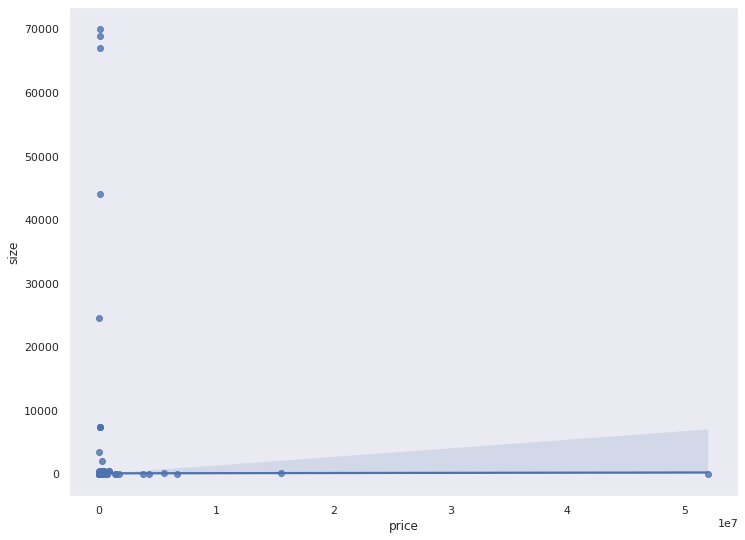

In [45]:
plt.figure(figsize=(12,9))
sns.regplot(data=new_df, x='price',y='size')
plt.grid()
plt.show()

In [46]:
arr = np.array(dropping)

In [47]:
# new_df.drop(new_df[(new_df['price']>300000)&(new_df['size']<200)].index,inplace=True)

In [48]:
# new_df[(new_df['size']>200)&(new_df['rooms']==7)]

In [49]:
new_df.drop(arr,inplace=True)

In [50]:
fig = px.scatter(x=new_df['price'],y=new_df['size'])
fig.show()

In [84]:
some = new_df.drop(new_df[new_df['price']>350000].index).copy()

In [85]:
# some = some.drop(some[(some['size']>250)&(some['price']<250000)].index)

In [86]:
some[(some['size']>250)&(some['price']>250000)]

,location,district,rooms,size,level,max_levels,price
307,"город Ташкент, Юнусабадский район, ц-5 Киёт (Ц...",Юнусабадский,5,255,1,8,270000
308,"город Ташкент, Юнусабадский район, ц-5 Киёт (Ц...",Юнусабадский,6,266,1,8,285000
1553,"город Ташкент, Мирабадский район, Шахрисабз",Мирабадский,4,280,4,8,320000
1649,"город Ташкент, Шайхантахурский район, Ипакчи",Шайхантахурский,6,268,1,3,260000
1700,"город Ташкент, Юнусабадский район, Минор",Юнусабадский,5,254,1,8,285000
1701,"город Ташкент, Юнусабадский район, Киёт",Юнусабадский,6,252,1,8,285000
1934,"город Ташкент, Юнусабадский район, Кичик Халка...",Юнусабадский,5,280,6,8,320000
1945,"город Ташкент, Юнусабадский район, ц-5 Киёт (Ц...",Юнусабадский,5,254,1,8,285000
1946,"город Ташкент, Юнусабадский район, ц-4 Кашгар ...",Юнусабадский,6,252,1,8,285000
1968,"город Ташкент, Юнусабадский район, Киёт",Юнусабадский,6,252,1,8,285000


In [87]:
corr2 = new_df.corrwith(new_df['price'])*100
corr3 = some.corrwith(some['price'])*100

In [88]:
pd.DataFrame([corr1,corr2,corr3],index=['new','new_df','some'])

,rooms,size,level,max_levels,price
new,61.840400,75.572504,9.608843,26.862571,100.0
new_df,55.354415,79.452753,6.478950,23.986376,100.0
some,56.205107,79.660606,6.817098,24.247264,100.0


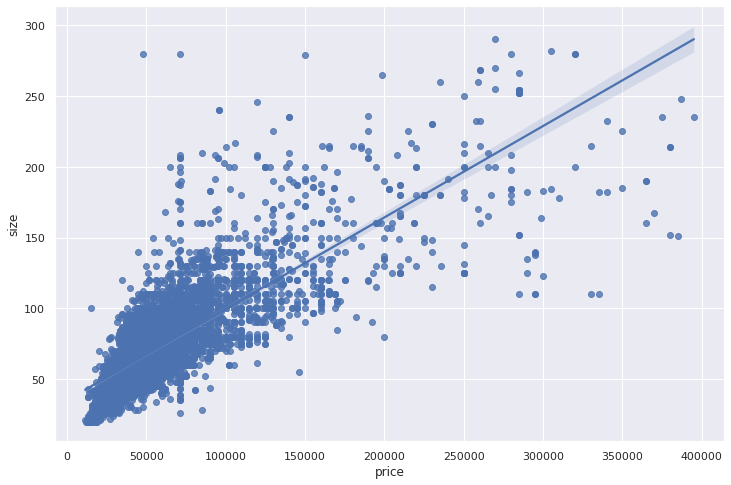

In [89]:
plt.figure(figsize=(12,8))
sns.regplot(data=new_df, x='price',y='size')
plt.show()

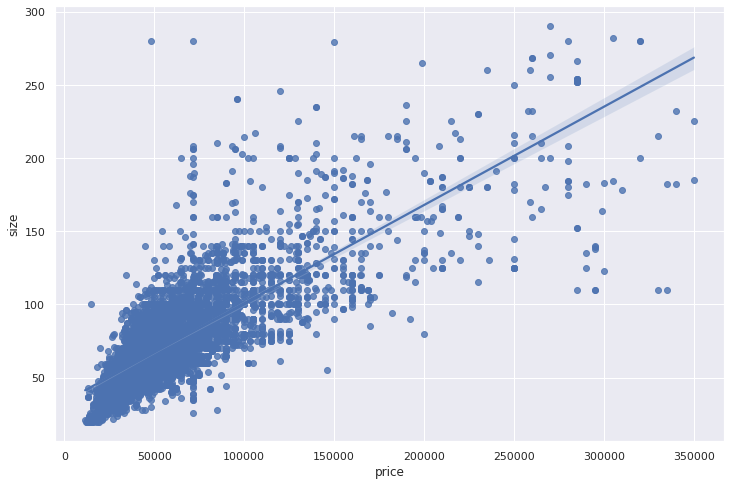

In [90]:
plt.figure(figsize=(12,8))
sns.regplot(data=some, x='price',y='size')
plt.show()

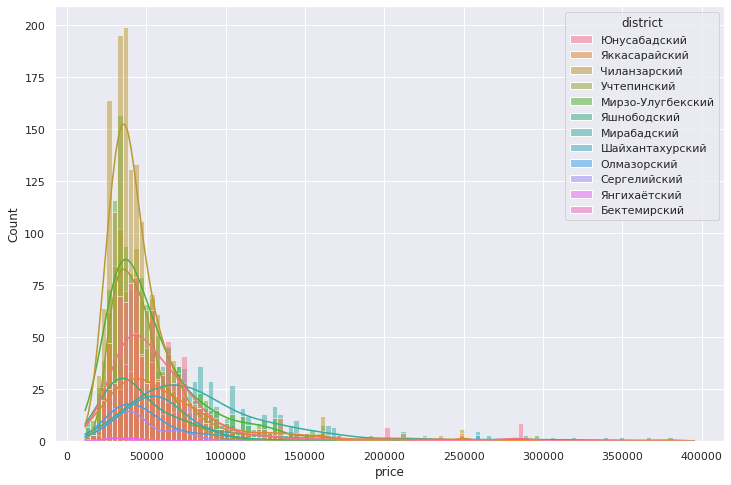

In [ ]:
plt.figure(figsize=(12,8))
sns.histplot(data=new_df, x='price',hue='district',kde=True)
plt.show()

In [ ]:
px.histogram(new_df['price'])

In [ ]:
ne_df = new_df.drop(['district','location'],axis=1)

In [76]:
some

,district,rooms,size,level,max_levels,price
0,Юнусабадский,3,57,4,4,52000
1,Яккасарайский,2,52,4,5,56000
2,Чиланзарский,2,42,4,4,37000
3,Чиланзарский,3,65,1,4,49500
4,Чиланзарский,3,70,3,5,55000
...,...,...,...,...,...,...
7559,Шайхантахурский,1,28,2,4,23000
7560,Яшнободский,1,38,5,5,24500
7561,Яшнободский,2,49,1,4,32000
7562,Шайхантахурский,2,64,3,9,40000


In [91]:
some = some.drop('location',axis=1)

In [92]:
some2 = some.drop('district',axis=1).copy()

In [105]:
new_df = new_df.drop('location',axis=1)

In [106]:
X_train, X_test = train_test_split(new_df, test_size=0.25, random_state=42)

In [180]:
x_train, x_test = train_test_split(some, test_size=0.25, random_state=42)

In [181]:
new_x = x_train.drop('price',axis=1)
y_train = x_train['price']
new_x_t = x_test.drop('price',axis=1)
y_test = x_test['price']

In [107]:
X_for_train = X_train.drop('price',axis=1)
y_for_train = X_train['price']
X_for_test = X_test.drop('price',axis=1)
y_for_test = X_test['price']

In [98]:
def preprocess(x):
    num_attribs = []
    obj_attribs = []
    for i in x.columns:
      if x[i].dtype=='O':
        obj_attribs.append(i)
      else:
        num_attribs.append(i)
    num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])
    full_pipeline = ColumnTransformer([
      ('num', num_pipeline, num_attribs),
      ('cat', OneHotEncoder(sparse=False), obj_attribs)
    ])
    y = full_pipeline.fit_transform(x)
    return y

In [108]:
X = preprocess(X_for_train)
X_t = preprocess(X_for_test)

In [182]:
x = preprocess(new_x)
x_t = preprocess(new_x_t)

In [ ]:
X_for_train['district'].value_counts()

Чиланзарский         1212
Мирзо-Улугбекский    1023
Юнусабадский          659
Учтепинский           649
Мирабадский           575
Яккасарайский         495
Яшнободский           355
Шайхантахурский       279
Олмазорский           195
Сергелийский          141
Янгихаётский           12
Бектемирский            5
Name: district, dtype: int64

In [ ]:
X_for_test['district'].value_counts()

Чиланзарский         422
Мирзо-Улугбекский    335
Учтепинский          224
Юнусабадский         217
Мирабадский          183
Яккасарайский        159
Яшнободский          110
Шайхантахурский      109
Олмазорский           71
Сергелийский          31
Янгихаётский           3
Бектемирский           3
Name: district, dtype: int64

In [109]:
X_t[1]

array([ 0.36113728,  0.43060519, -0.76390729, -0.76504713,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

In [110]:
X[1]

array([-0.5904384 , -0.9511837 , -1.20609515, -0.79039753,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

In [101]:
x

array([[ 0.3682371 ,  0.3424118 ,  0.12650626, -0.78865617],
       [-0.58729973, -0.9505978 , -1.20909413, -0.78865617],
       [ 1.32377393,  1.03402159,  1.01690652,  1.11984534],
       ...,
       [ 0.3682371 ,  0.82353165, -0.31869387, -0.78865617],
       [-0.58729973, -0.77017785,  0.12650626, -0.40695587],
       [-0.58729973, -0.74010786,  0.57170639,  1.11984534]])

In [68]:
models = {
    'SVC':SVC(),
    'XGBoost':XGBRegressor(),
    'LinearRegression': LinearRegression(),
    'RandomForest':RandomForestRegressor(),
    'DecisionTree':DecisionTreeRegressor(),
    'SGDRegressor':SGDRegressor(),
    'Perceptron':Perceptron(),
    'Ridge':Ridge(),
    'BayesianRigde':BayesianRidge(),
    'AdaBoostRegressor':AdaBoostRegressor(),
    'BaggingRegressor':BaggingRegressor(),
    'GradientBoosting':GradientBoostingRegressor(),
    'HistGradientBoosting':HistGradientBoostingRegressor(),
    'ExtraTree': ExtraTreeRegressor(),
    'NuSVR':NuSVR(),
    'LinearSVR':LinearSVR(),
    'XGBoostF':XGBRFRegressor()
}

In [111]:
model_results = []
model_names = []
model_results_percent = []
# training the model with function
for name,model in models.items():
    a = model.fit(X,y_for_train)
    predicted = a.predict(X_t)
    score1 = np.sqrt(mean_squared_error(y_for_test, predicted))
    score2 = str(np.around(r2_score(y_for_test,predicted)*100))+'%'
    model_results.append(score1)
    model_results_percent.append(score2)
    model_names.append(name)
    
    #creating dataframe
    df_results = pd.DataFrame([model_names,model_results,model_results_percent])
    df_results = df_results.transpose()
    df_results = df_results.rename(columns={0:'Model',1:'RMSE',2:'R2 score'}).sort_values(by='RMSE',ascending=False)
    
print(df_results)

[19:15:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:15:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
                   Model          RMSE R2 score
15             LinearSVR  67315.462117  -155.0%
14                 NuSVR  42661.805435    -2.0%
6             Perceptron  38774.910395    16.0%
0                    SVC   30258.54162    49.0%
13             ExtraTree  25208.007668    64.0%
4           DecisionTree  24998.684652    65.0%
9      AdaBoostRegressor   23996.47229    68.0%
16              XGBoostF  23961.011876    68.0%
5           SGDRegressor  23474.146981    69.0%
2       LinearRegression   23398.41365    69.0%
7                  Ridge   23397.32761    69.0%
8          BayesianRigde  23397.313433    69.0%
11      GradientBoosting  21931.898663    73.0%
1                XGBoost  21758.714843    73.0%
12  HistGradientBoosting  

In [117]:
model_results = []
model_names = []
model_results_percent = []
# training the model with function
for name,model in models.items():
    a = model.fit(x,y_train)
    predicted = a.predict(x_t)
    score1 = np.sqrt(mean_squared_error(y_test, predicted))
    score2 = str(np.around(r2_score(y_test,predicted)*100))+'%'
    model_results.append(score1)
    model_results_percent.append(score2)
    model_names.append(name)
    
    #creating dataframe
    df_results = pd.DataFrame([model_names,model_results,model_results_percent])
    df_results = df_results.transpose()
    df_results = df_results.rename(columns={0:'Model',1:'RMSE',2:'R2 score'}).sort_values(by='RMSE',ascending=False)

[19:17:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:17:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [118]:
df_results

,Model,RMSE,R2 score
15,LinearSVR,64819.965874,-176.0%
14,NuSVR,39511.743632,-2.0%
6,Perceptron,35976.504794,15.0%
0,SVC,27921.325262,49.0%
13,ExtraTree,26366.025448,54.0%
4,DecisionTree,26363.482408,54.0%
9,AdaBoostRegressor,24177.589304,62.0%
16,XGBoostF,22603.432819,66.0%
5,SGDRegressor,21068.48005,71.0%
8,BayesianRigde,21028.786817,71.0%


In [ ]:
my_home = [5,121,1,1]

In [ ]:
X_for_test.iloc[0]=my_home

In [ ]:
xgbf = XGBRFRegressor()
xgbf.fit(X, y_for_train)

[14:35:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRFRegressor()

In [ ]:
xgbf.predict(X_t)

array([34933.63 , 65237.363, 38024.023, ..., 64843.02 , 38024.023,
       64843.02 ], dtype=float32)

In [ ]:
xgb = XGBRegressor()
xgb.fit(X,y_for_train)

[14:35:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
xgb.predict(X_t)

array([21231.531, 69432.08 , 39444.363, ..., 65062.535, 40605.09 ,
       62594.44 ], dtype=float32)

In [119]:
rf = RandomForestRegressor(n_estimators=120, max_depth=12, 
                           criterion="absolute_error",min_samples_split=5,)
rf.fit(x,y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=12,
                      min_samples_split=5, n_estimators=120)

In [132]:
predicted = rf.predict(x_t)
score1 = np.sqrt(mean_squared_error(y_test, predicted))
score2 = str(np.around(r2_score(y_test,predicted)*100))+'%'

In [133]:
score1

18923.781418519226

In [134]:
score2

'77.0%'

In [141]:
hgdb = HistGradientBoostingRegressor(loss='poisson',learning_rate=0.075,
                                     max_iter=200,max_leaf_nodes=50,
                                     max_depth=20,l2_regularization=5,
                                     max_bins=150)
hgdb.fit(x,y_train)

HistGradientBoostingRegressor(l2_regularization=5, learning_rate=0.075,
                              loss='poisson', max_bins=150, max_depth=20,
                              max_iter=200, max_leaf_nodes=50)

In [142]:
predicted = hgdb.predict(x_t)
score1 = np.sqrt(mean_squared_error(y_test, predicted))
score2 = str(np.around(r2_score(y_test,predicted)*100))+'%'

In [143]:
score1

19139.563136129538

In [137]:
score2

'76.0%'

In [127]:
bgr = BaggingRegressor()
bgr.fit(x,y_train)

BaggingRegressor()

In [144]:
predicted = bgr.predict(x_t)
score1 = np.sqrt(mean_squared_error(y_test, predicted))
score2 = str(np.around(r2_score(y_test,predicted)*100))+'%'

In [145]:
score1

19116.61037970558

In [146]:
score2

'76.0%'

In [148]:
score3 = mean_absolute_error(y_test, predicted)
score3

10842.283316487206

In [149]:
params = {
    "n_estimators": 500,
    "max_depth": 5,
    "min_samples_split": 6,
    "learning_rate": 0.05,
    "loss": "absolute_error",
    'subsample':0.05,
}

In [151]:
grb = GradientBoostingRegressor(**params)
grb.fit(x,y_train)

GradientBoostingRegressor(learning_rate=0.05, loss='absolute_error',
                          max_depth=5, min_samples_split=6, n_estimators=500,
                          subsample=0.05)

In [152]:
predicted = grb.predict(x_t)
score1 = np.sqrt(mean_squared_error(y_test, predicted))
score2 = str(np.around(r2_score(y_test,predicted)*100))+'%'

In [153]:
score1

19836.389735649875

In [154]:
score2

'74.0%'

In [183]:
experiment = ['Юнусабадский',10,340,1,1]

In [184]:
new_x_t.iloc[0] = experiment

In [185]:
X_new = preprocess(new_x_t)

In [186]:
predicted_price = rf.predict(X_new)

In [187]:
new_x_t['predicted_price'] = predicted_price

In [188]:
new_x_t

,district,rooms,size,level,max_levels,predicted_price
5753,Юнусабадский,10,340,1,1,197741.433333
2206,Мирабадский,4,135,5,5,140535.591667
1155,Учтепинский,4,90,3,5,58749.995833
6740,Яшнободский,2,54,2,9,39335.362500
3507,Юнусабадский,2,55,3,4,37582.033333
...,...,...,...,...,...,...
645,Чиланзарский,3,80,9,9,54815.333333
2792,Юнусабадский,2,50,2,4,36009.150000
7177,Яккасарайский,3,78,6,8,61934.908333
4304,Шайхантахурский,2,58,3,4,42507.475000


In [ ]:
x_train,x_test = train_test_split(ne_df, test_size=0.25,random_state=42)

In [ ]:
x = x_train.drop('price',axis=1)
y2 = x_train['price']
x_t = x_test.drop('price',axis=1)
y2_t = x_test['price']

In [ ]:
x = preprocess(x)
x_t = preprocess(x_t)

In [ ]:
model_name = []
model_accuracy = []
model_loss = []
for name, model in models.items():
    a = model.fit(x,y2)
    predicted = a.predict(x_t)
    score1 = np.sqrt(mean_squared_error(y2_t, predicted))
    score2 = str(np.around(r2_score(y2_t,predicted)*100))+'%'
    model_loss.append(score1)
    model_accuracy.append(score2)
    model_name.append(name)
    
    #creating dataframe
    df_results = pd.DataFrame([model_name,model_loss,model_accuracy])
    df_results = df_results.transpose()
    df_results = df_results.rename(columns={0:'Model',1:'RMSE',2:'R2 score'}).sort_values(by='RMSE',ascending=False)

[16:07:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:07:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
df_results

,Model,RMSE,R2 score
15,LinearSVR,67881.81426,-159.0%
14,NuSVR,42621.151141,-2.0%
6,Perceptron,40462.452733,8.0%
0,SVC,31183.5441,45.0%
13,ExtraTree,26341.024733,61.0%
4,DecisionTree,25374.722263,64.0%
5,SGDRegressor,24157.906348,67.0%
8,BayesianRigde,24144.295197,67.0%
7,Ridge,24143.889202,67.0%
2,LinearRegression,24143.066959,67.0%


In [174]:

import pickle
import joblib
  
# Save the trained model as a pickle string.
saved_model = pickle.dumps(rf)

In [175]:
joblib.dump(rf, 'rf_for_sales1.pkl')

['rf_for_sales1.pkl']

In [189]:
some

,district,rooms,size,level,max_levels,price
0,Юнусабадский,3,57,4,4,52000
1,Яккасарайский,2,52,4,5,56000
2,Чиланзарский,2,42,4,4,37000
3,Чиланзарский,3,65,1,4,49500
4,Чиланзарский,3,70,3,5,55000
...,...,...,...,...,...,...
7559,Шайхантахурский,1,28,2,4,23000
7560,Яшнободский,1,38,5,5,24500
7561,Яшнободский,2,49,1,4,32000
7562,Шайхантахурский,2,64,3,9,40000


In [177]:
some['rooms'].value_counts()

2    2736
3    2332
4    1121
1     966
5     248
6      42
7       9
8       2
Name: rooms, dtype: int64